In [535]:
from sklearn.model_selection import train_test_split
from pandas import DataFrame, read_csv, concat, get_dummies, Series
from sklearn import metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import plot_importance, XGBRegressor
from pprint import pprint
from json import load
import seaborn as sns
import numpy as np
from math import sqrt

%matplotlib inline

In [536]:
project = 'house-prices'
version='v0.1'

In [537]:
fulltrain=read_csv('./train.csv',index_col=0)
test=read_csv('./test.csv',index_col=0)
fixed_seed=1234578416
train80, valid20 = train_test_split(fulltrain, test_size=0.2, random_state=fixed_seed)

In [538]:
categories = load(open('categories.json',"r"))
categories.pop('OverallQual')
categories.pop('OverallCond')
categories

{'MSSubClass': [20,
  30,
  40,
  45,
  50,
  60,
  70,
  75,
  80,
  85,
  90,
  120,
  150,
  160,
  180,
  190],
 'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'],
 'Street': ['Grvl', 'Pave'],
 'Alley': ['Grvl', 'Pave', 'NA'],
 'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
 'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
 'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
 'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
 'LandSlope': ['Gtl', 'Mod', 'Sev'],
 'Neighborhood': ['Blmngtn',
  'Blueste',
  'BrDale',
  'BrkSide',
  'ClearCr',
  'CollgCr',
  'Crawfor',
  'Edwards',
  'Gilbert',
  'IDOTRR',
  'MeadowV',
  'Mitchel',
  'Names',
  'NoRidge',
  'NPkVill',
  'NridgHt',
  'NWAmes',
  'OldTown',
  'SWISU',
  'Sawyer',
  'SawyerW',
  'Somerst',
  'StoneBr',
  'Timber',
  'Veenker'],
 'Condition1': ['Artery',
  'Feedr',
  'Norm',
  'RRNn',
  'RRAn',
  'PosN',
  'PosA',
  'RRNe',
  'RRAe'],
 'Condition2': ['Artery',
  'Feedr',
  'Norm',
  'RRNn',
  'RRAn',
  'PosN',
  '

In [539]:

#train80_qual = train80.select_dtypes(exclude=np.number)
#valid20_qual = valid20.select_dtypes(exclude=np.number)
#test_qual = test.select_dtypes(exclude=np.number)
#train80 = train80.select_dtypes(include=np.number)
#valid20 = valid20.select_dtypes(include=np.number)
#test = test.select_dtypes(include=np.number)

fields=['MoSold', 'YrSold','Utilities','MiscVal', 'PoolArea']

train80.drop(fields, axis=1, inplace=True)
valid20.drop(fields, axis=1, inplace=True)
test.drop(fields, axis=1, inplace=True)

for key in fields:
    categories.pop(key, None)


qual_columns = list(categories.keys())

/home/guillaume/.virtualenvs/House-Prices/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [540]:
categories['Neighborhood'][categories['Neighborhood'].index('Names')]='NAmes'

In [541]:
qual_columns

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [542]:
train80.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'O

In [543]:
for category in categories.keys():
    # print(categories[category])
    train80.loc[:,category] = train80[category].astype('category',categories=categories[category])
    valid20.loc[:,category] = valid20[category].astype('category',categories=categories[category])
    test.loc[:,category] = test[category].astype('category',categories=categories[category])

/home/guillaume/.virtualenvs/House-Prices/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/guillaume/.virtualenvs/House-Prices/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Remove outliers

In [544]:
train80 = train80.drop(train80[train80.LotArea > 200000].index)
train80 = train80.drop(train80[train80.LotFrontage > 250].index)

In [545]:
train80.loc[:,'SalePrice']=np.log(train80.loc[:,'SalePrice'])
valid20.loc[:,'SalePrice']=np.log(valid20.loc[:,'SalePrice'])

In [546]:
mean = {}
mode = {}
median ={}
for column in list(train80.columns):
    if column not in qual_columns:
        mean[column]=train80[column].mean()
        mode[column]=train80[column].mode()[0]
        median[column]=train80[column].median()

In [547]:
mean_price_neigh={}

neighborhoods = categories['Neighborhood']
for name in list(neighborhoods):
    mean_price_neigh[name]=train80.loc[train80['Neighborhood']==name,'SalePrice'].mean()

In [548]:
train80

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
177,60,RL,97.0,10029,Pave,NaN,IR1,Lvl,Corner,Gtl,...,228,0,0,192,NaN,NaN,NaN,WD,Normal,12.259613
148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,CulDSac,Gtl,...,48,0,0,0,NaN,NaN,NaN,WD,Normal,12.312682
1229,120,RL,65.0,8769,Pave,NaN,Reg,Lvl,Corner,Gtl,...,72,0,0,224,NaN,NaN,NaN,New,Partial,12.813918
1085,60,RL,NaN,13031,Pave,NaN,IR2,Lvl,Corner,Gtl,...,44,0,0,0,NaN,NaN,NaN,WD,Normal,12.141534
160,60,RL,134.0,19378,Pave,NaN,IR1,HLS,Corner,Gtl,...,132,0,168,0,NaN,NaN,NaN,New,Partial,12.676076
1175,70,RL,80.0,16560,Pave,NaN,IR1,Lvl,Inside,Gtl,...,0,0,0,0,NaN,NaN,NaN,WD,Normal,12.384219
1029,50,RL,79.0,9492,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,0,0,NaN,NaN,NaN,WD,Normal,11.561716
285,120,RL,50.0,8012,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,52,0,0,NaN,NaN,NaN,WD,Normal,12.096258
739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,Inside,Gtl,...,0,0,0,0,NaN,NaN,NaN,WD,Alloca,12.095141


In [549]:
target_column='SalePrice'
X_train = train80.drop(target_column, axis=1)
y_train = train80[target_column]
X_val = valid20.drop(target_column, axis=1)
y_val = valid20[target_column]

In [550]:
for name in list(neighborhoods):
    X_train.loc[X_train['Neighborhood']==name,'mean_price']=mean_price_neigh[name]
    X_val.loc[X_val['Neighborhood']==name,'mean_price']=mean_price_neigh[name]
    test.loc[test['Neighborhood']==name,'mean_price']=mean_price_neigh[name]
X_train.loc[X_train['Neighborhood'].isna(),'mean_price']=mean['SalePrice']
X_val.loc[X_val['Neighborhood'].isna(),'mean_price']=mean['SalePrice']
test.loc[test['Neighborhood'].isna(),'mean_price']=mean['SalePrice']

# train80_qual['Neighborhood']
#mean_price_neigh

In [551]:
mean_price_neigh

{'Blmngtn': 12.173363324726896,
 'Blueste': 11.82653598019212,
 'BrDale': 11.53964401483993,
 'BrkSide': 11.674533811574596,
 'ClearCr': 12.233040517899122,
 'CollgCr': 12.156023010236876,
 'Crawfor': 12.210102080261207,
 'Edwards': 11.700701537327404,
 'Gilbert': 12.141858300326511,
 'IDOTRR': 11.413642633483924,
 'MeadowV': 11.483857308594569,
 'Mitchel': 11.917407686903347,
 'NAmes': 11.859500546411475,
 'NoRidge': 12.679755894797925,
 'NPkVill': 11.86530819060954,
 'NridgHt': 12.60881146902959,
 'NWAmes': 12.124451484343995,
 'OldTown': 11.708025486518816,
 'SWISU': 11.822611122408366,
 'Sawyer': 11.8087375018709,
 'SawyerW': 12.068090833072748,
 'Somerst': 12.30918012612974,
 'StoneBr': 12.630205647345603,
 'Timber': 12.356327186922666,
 'Veenker': 12.367692362785048}

In [552]:
for df in [X_train, X_val, test]:
    na_sum = df['mean_price'].isna().sum()
    print(na_sum[na_sum!=0])

[]
[]
[]


In [553]:
for df in [X_train, X_val, test]:
    df.loc[:,'Exterior1st'] = df['Exterior1st'].fillna('VinylSd')
    df.loc[:,'Exterior2nd'] = df['Exterior2nd'].fillna('VinylSd')

    df.loc[:,'Functional'] = df['Functional'].fillna('Typ')
    df.loc[:,'MSZoning'] = df['MSZoning'].fillna('RL')
    df.loc[:,'SaleType'] = df['SaleType'].fillna('WD')
#    for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType'):
#        df.loc[:,col] = df[col].fillna('None')
#    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType'):
#        df.loc[:,col] = df[col].fillna('None')
    
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'):
        df.loc[:,col] = df[col].fillna(0)
    
#    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#        df.loc[:,col] = df[col].fillna('None')    

    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df.loc[:,col] = df[col].fillna(0)
        
    df.loc[:,'Electrical'] = df['Electrical'].fillna('SBrkr')
    df.loc[:,'LotFrontage'] = df['LotFrontage'].fillna(median['LotFrontage'])

    for col in ('BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'):
        df.loc[:,col] = df[col].fillna('NA')
    for col in ('ExterQual', 'KitchenQual'):
        df.loc[:,col] = df[col].fillna('TA')

In [554]:
#X_train = get_dummies(X_train, columns=qual_columns, drop_first=True)
#X_val = get_dummies(X_val, columns=qual_columns, drop_first=True)
#test = get_dummies(test, columns=qual_columns, drop_first=True)



In [555]:
X_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'O

In [556]:
ordinal_cols={}
for key, value in list(categories.items()):
    if value[0] == 'Ex':
        ordinal_cols[key] = value
        categories.pop(key)

for col, tags in ordinal_cols.items():
    tags.reverse()
    for df in [X_train, X_val, test]:
        for i, tag in enumerate(tags):
            df.loc[ df[col]==tags[i], col+'_ord']= i
        df.drop(col, axis=1, inplace=True)


In [557]:
#for category in categories.keys():
X_train = concat([X_train,
                  get_dummies(X_train[list(categories.keys())])
                 ],axis=1).drop(list(categories.keys()),axis=1)
X_val = concat([X_val,
                  get_dummies(X_val[list(categories.keys())])
                 ],axis=1).drop(list(categories.keys()),axis=1)
test = concat([test,
                  get_dummies(test[list(categories.keys())])
                 ],axis=1).drop(list(categories.keys()),axis=1)


In [558]:
pprint(X_train.columns)
print(X_train.shape[0])

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_ConLI', 'SaleType_ConLD', 'SaleType_Oth',
       'SaleCondition_Normal', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Partial'],
      dtype='object', length=283)
1166


Surface Area

In [559]:
for df in [X_train, X_val, test]:
    # df['Surface1'] =  df['2ndFlrSF'] * 0.67918 + df['1stFlrSF'] * 0.15835 + df['TotalBsmtSF'] * 0.56624
    # df['Surface2'] =  df['1stFlrSF'] * 0.51 + df['TotalBsmtSF'] * 0.35
    df['Surface'] =  df['2ndFlrSF'] + df['1stFlrSF'] + df['TotalBsmtSF']
#    df.drop('2ndFlrSF', axis=1, inplace=True)
#    df.drop('1stFlrSF', axis=1, inplace=True)
#    df.drop('TotalBsmtSF', axis=1, inplace=True)
    df.drop('GrLivArea', axis=1, inplace=True)
#    df['Garage'] = df['GarageCond'] + df['GarageFinish'] + df['GarageQual'] + df['GarageCars']

In [560]:
for df in [X_train, X_val, test]:
    na_sum = df.isna().sum()
    print(na_sum[na_sum!=0])

Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


In [561]:
zero_cols=X_train.columns[( X_train == 0).all()]
display(zero_cols)

Index(['MSSubClass_150', 'MSZoning_A', 'MSZoning_C', 'MSZoning_I',
       'MSZoning_RP', 'Alley_NA', 'Condition2_RRNe', 'BldgType_2FmCon',
       'BldgType_Duplx', 'BldgType_TwnhsI', 'RoofMatl_ClyTile',
       'RoofMatl_Membran', 'RoofMatl_Tar', 'Exterior1st_Other',
       'Exterior1st_PreCast', 'Exterior1st_Wd', 'Exterior2nd_BrkComm',
       'Exterior2nd_CemntBd', 'Exterior2nd_PreCast', 'Exterior2nd_Wd',
       'Exterior2nd_WdShing', 'MasVnrType_CBlock', 'BsmtExposure_NA',
       'BsmtFinType1_NA', 'BsmtFinType2_NA', 'Functional_Sal', 'GarageType_NA',
       'GarageFinish_NA', 'Fence_NA', 'MiscFeature_Elev', 'MiscFeature_TenC',
       'MiscFeature_NA', 'SaleType_VWD'],
      dtype='object')

In [562]:
for df in [X_train, X_val, test]:
    df.drop(columns=zero_cols, inplace=True)

In [563]:
# normalization
scaler = StandardScaler()
scaler.fit(X_train)

X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)
test[:] = scaler.transform(test)

/home/guillaume/.virtualenvs/House-Prices/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


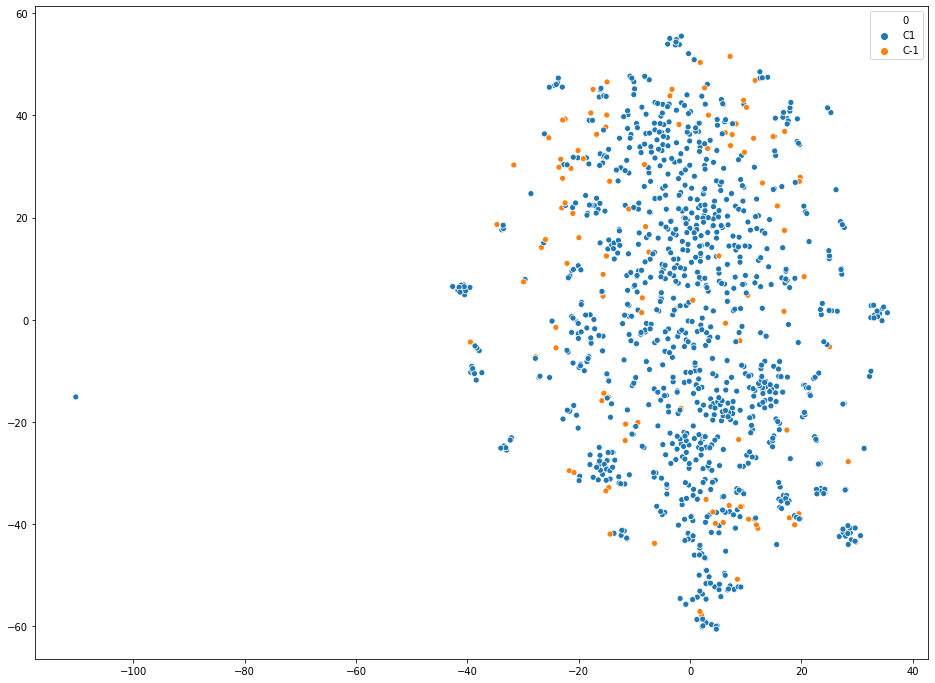

In [564]:
clf = IsolationForest(max_samples=100, random_state=42, behaviour='new')
clf.fit(X_train)
y_pred_train = DataFrame(data=clf.predict(X_train),index=X_train.index)
y_pred_train_str = ('C' + y_pred_train.astype('str'))[0]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(16,12))
ax =sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_pred_train_str)

In [565]:
isnotoutlier = (y_pred_train[0]==1)
X_train = X_train.loc[isnotoutlier,:]
y_train = y_train.loc[isnotoutlier]
(y_pred_train[0]==-1).sum()

117

In [566]:
zero_cols = X_train.columns[( X_train == 0).all()]
display(zero_cols)
for df in [X_train, X_val, test]:
    df.drop(columns=zero_cols, inplace=True)
X_train.shape

Index([], dtype='object')

(1049, 250)

In [389]:
params = {'min_child_weight':[6,7,8,9], 'gamma':[i/100.0 for i in range(1,5)],  'subsample':[i/10.0 for i in range(2,5)],
'colsample_bytree':[i/10.0 for i in range(8,10)], 'max_depth': [3,4,5]}

model = XGBRegressor(booster="gbtree")
grid = GridSearchCV(model, params)
grid.fit(X_train, y_train)
grid.best_params_

/home/guillaume/.virtualenvs/House-Prices/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'colsample_bytree': 0.9,
 'gamma': 0.04,
 'max_depth': 5,
 'min_child_weight': 7,
 'subsample': 0.4}

In [390]:
model = XGBRegressor(booster="gbtree",colsample_bytree=0.9,
                     max_depth=5, n_estimators=400, gamma= 0.04,
                     min_child_weight=7,
                     subsample=0.4)

In [567]:
model = XGBRegressor(booster="gbtree",colsample_bytree=0.5,
                     max_depth=3, n_estimators=400, subsample=0.7)

In [568]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.7)

In [569]:
y_pred = model.predict(X_val)

In [570]:
RMSLE = sqrt(mean_squared_error(y_val,y_pred))
RMSLE

0.12361576184867011

In [571]:
test_pred = model.predict(test)

In [572]:
submission = DataFrame({"SalePrice": np.exp (test_pred)}, index=test.index)
submission.to_csv('test-prediction.csv')

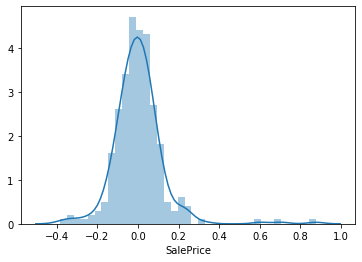

In [573]:
sns.distplot(y_pred-y_val)
plt.show()

0.040398573186946486


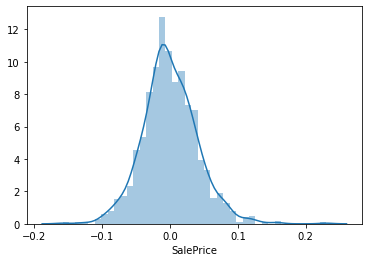

In [574]:
y_t_pred = model.predict(X_train)
print(sqrt(mean_squared_error(y_train,y_t_pred)))
sns.distplot(y_t_pred-y_train)
plt.show()

In [575]:
importance_dict = model.get_booster().get_score(importance_type="gain")
importance = DataFrame.from_dict(importance_dict, orient='index')[0].sort_values(ascending=False)
order = list(importance.index)

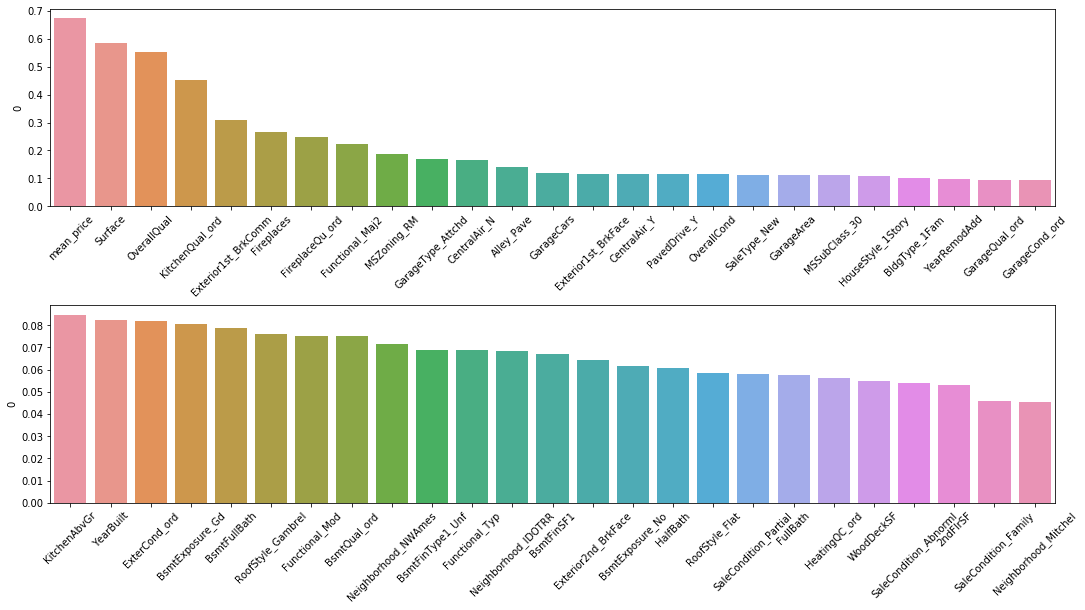

In [576]:
nb_bars = 25

plt.figure(figsize=(18,20))
plt.subplots_adjust(hspace=0.5)
for i in range(0,2):
    plt.subplot(4,1,i+1)
    low = nb_bars*i
    hi = nb_bars*(i+1)
    bars = sns.barplot(x=importance[low:hi].index, y=importance[low:hi])
    bars.set_xticklabels(bars.get_xticklabels(), rotation=45)
plt.show()

In [577]:
X_train = X_train[order]
X_val = X_val[order]
test = test[order]
X_train.shape

(1049, 178)

In [578]:
X_train.to_csv('X_train.csv')
X_val.to_csv('X_val.csv')
test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv', header=True)
y_val.to_csv('y_val.csv', header=True)